In [2]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/\(데이콘\)운동동작분류/data ./

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, MaxPool1D, SeparableConv1D, AvgPool1D, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Flatten, Activation, Dropout, BatchNormalization, Input, Add, GlobalAvgPool1D, Subtract, Reshape, Concatenate, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('./data/train_features.csv')
train_x = df.values[:,2:].reshape(-1,600,6)
print(train_x.shape)
# df

(3125, 600, 6)


In [5]:
df = pd.read_csv('./data/train_labels.csv')
train_y = df.values[:,1].astype(np.int)
print(train_y.shape)
df

(3125,)


,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [6]:
def show_data(x, label):
  print(label)
  data = x
  fig = plt.figure(figsize=(14,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax1.plot(data[:,0], label='acc_x')
  ax1.plot(data[:,1], label='acc_y')
  ax1.plot(data[:,2], label='acc_z')
  ax1.grid()
  ax1.legend()
  ax2.plot(data[:,3], label='gy_x')
  ax2.plot(data[:,4], label='gy_y')
  ax2.plot(data[:,5], label='gy_z')
  ax2.grid()
  ax2.legend()

  plt.show()

In [7]:
from scipy import signal

def get_period(data_x): # (6)
  periods = []
  ch = data_x.shape[1]
  top_n = 3

  for i in range(ch):
    f, Pxx = signal.periodogram(data_x[:,i])
    freq_indices = np.flip(np.argsort(Pxx), 0)[0:top_n]
    freq = f[freq_indices]
    period = np.around(1 / np.array(freq))
    periods.append(period.tolist())
  
  periods = np.array(periods, dtype=np.int).swapaxes(0,1) # (3, ch)
  
  wei = []
  for i in range(top_n):
    wei += [0.8**i] * ch

  pers = []
  cnt = np.bincount(periods.reshape(-1), weights=wei)#[1]*ch + [0.8]*ch + [0.5]*ch)
  for i in range(3):
    per = np.argmax(cnt)
    pers.append(per)
    cnt[per] = 0

  return pers

In [14]:
def longer(X, size):
  assert len(X) < size

  ind = np.arange(len(X))
  ind = np.around(ind/ind[-1] * (size-1)).astype(int)

  if len(X.shape) == 2:
    temp = np.zeros((size, X.shape[1]))
  elif len(X.shape) == 1:
    temp = np.zeros((size))
  
  for i in range(len(X)-1):
    gap = ind[i+1] - ind[i]
    temp[ind[i]:ind[i+1]] = np.linspace(X[i], X[i+1], gap, endpoint=False)
  temp[-1] = X[-1]
  return temp

In [8]:
get_period(train_x[103])

[120, 60, 100]

In [12]:
rand_idx = np.random.randint(100,300)

In [15]:
temp = longer(train_x[103, rand_idx:rand_idx+120], 600)
temp.shape

(600, 6)

55


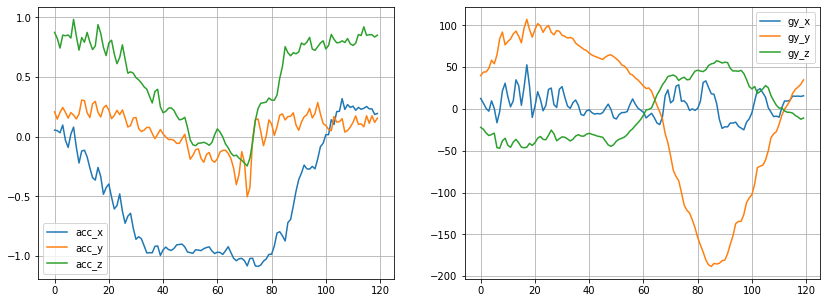

In [16]:
show_data(train_x[103, rand_idx:rand_idx+120], train_y[103])

55


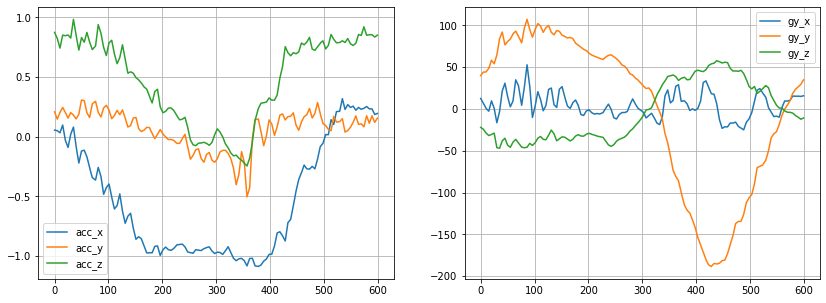

In [17]:
show_data(temp, train_y[103])